<a href="https://colab.research.google.com/github/aiyingliulang/Play-with-Machine-Learning-Algorithms/blob/master/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.ticker as ticker
import statsmodels.api as sm 
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA #模型

from statsmodels.stats.stattools import durbin_watson #DW检验
from statsmodels.graphics.api import qqplot #qq图

import itertools

import warnings
warnings.filterwarnings("ignore")

In [3]:
path = "test.xlsx"
df1 = pd.read_excel(path,
                #  na_values=[' ',0],
                usecols=['Date','oil/day'])
df1['Date']=pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace=True)
df1

,oil/day
Date,
2013-09-01,318.03
2013-10-01,376.77
2013-11-01,337.63
2013-12-01,241.74
2014-01-01,224.87
...,...
2021-08-01,10.42
2021-09-01,10.63
2021-10-01,11.19


In [4]:
df = pd.read_excel(path,
                #  na_values=[' ',0],
                 usecols=['Date','oil/day'])
df['Date']=pd.to_datetime(df['Date'])
df

,Date,oil/day
0,2013-09-01,318.03
1,2013-10-01,376.77
2,2013-11-01,337.63
3,2013-12-01,241.74
4,2014-01-01,224.87
...,...,...
93,2021-08-01,10.42
94,2021-09-01,10.63
95,2021-10-01,11.19
96,2021-11-01,10.63


In [5]:
df1.index[58:]

DatetimeIndex(['2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

Text(0.5, 1.0, 'Oil Production')

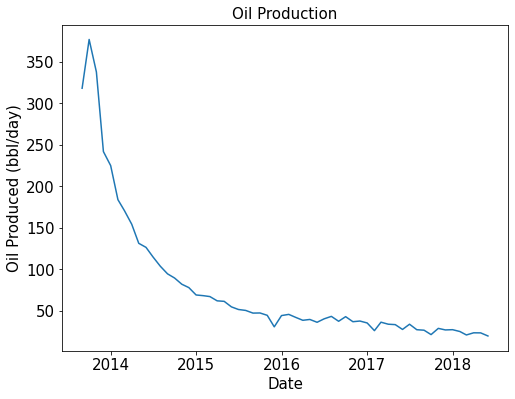

In [6]:
ts=df1['oil/day'][:58]
plt.figure(figsize=(8,6))

plt.plot(ts)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production',fontsize=15)

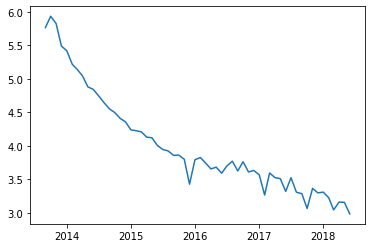

In [7]:
ts_log=np.log(ts)
plt.plot(ts_log)

Text(0.5, 1.0, 'Transformed Time Series')

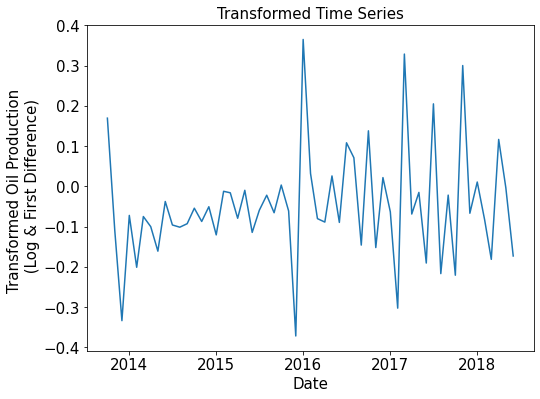

In [8]:
ts_log_diff=ts_log.diff(1)
plt.figure(figsize=(8,6))
plt.plot(ts_log_diff)
# # ts_log_diff

plt.xlabel('Date',fontsize=15)
plt.ylabel('Transformed Oil Production \n (Log & First Difference)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Transformed Time Series',fontsize=15)

In [9]:
from statsmodels.tsa.stattools import adfuller

def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def adf_test(timeseries):
    rolling_statistics(timeseries)#绘图
    print ('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def test_stationarity(timeseries):
    #Determing rolling statistics
    #计算移动平均，窗口大小为12 
    rolmean = timeseries.rolling(12).mean()
    #计算移动标准差，窗口大小为12
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [10]:
# ts_log_diff = ts_log - ts_log.shift(periods=1)
# # ts_log_diff=ts_log.diff(1)
# plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)

In [11]:
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print (last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data # return np.exp(tmp_data)也可以return到最原始，tmp_data是对原始数据取对数的结果

In [12]:
# from statsmodels.tsa.arima_model import ARIMA

# # ts_log_diff=ts_log_diff.dropna()

# model = ARIMA(ts_log,order=(1,1,0)) #第二个参数代表使用了一阶差分
# results_AR = model.fit(disp=-1)
# plt.plot(ts_log_diff)
# plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
# plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-ts_log_diff)**2))#残差平方和

Text(0.5, 1.0, 'R square: 0.22')

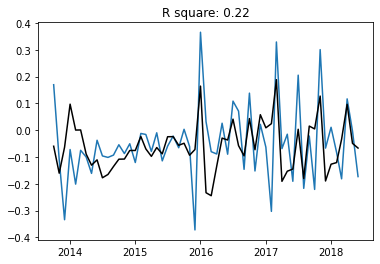

In [13]:
from statsmodels.tsa.arima_model import ARIMA

ts_log_diff=ts_log_diff.dropna()
#ARIMA
model = ARIMA(ts_log, order=(1, 1, 2))  #(1,1,2), RSS (4.9675), r2(0.31); (0, 1, 1) RSS (5.28), r2(0.26)
results_ARIMA = model.fit(disp=-1)  #不展示信息
plt.plot(ts_log_diff)
# plt.plot(results_ARIMA.fittedvalues, color='red')#和下面这句结果一样
plt.plot(results_ARIMA.predict(), color='black')#predict得到的就是fittedvalues，只是差分的结果而已。还需要继续回退
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
from sklearn.metrics import r2_score
plt.title('R square: %.2f'% r2_score(ts_log_diff,results_ARIMA.predict()))#

[2.9816333491744893]
R square: 0.95
RMSE: 16.88
MAE: 8.02


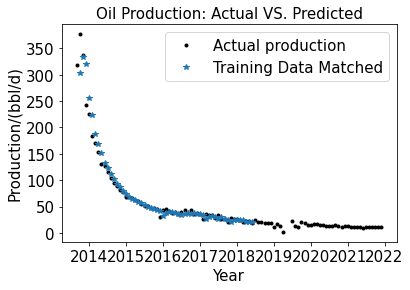

In [17]:
from statsmodels.tsa.arima_model import ARIMA

ts_log_diff = diff_ts(ts_log, d=[1])#调用差分方法，方便后续还原
model = ARIMA(ts_log, order=(0, 1, 1))  #建模, (0, 1, 1), r2=0.89
# model = ARIMA(ts_log, order=(1, 1, 2))  #建模, (1, 1, 2), r2=0.89; 
results_ARIMA = model.fit(disp=-1)  #fit
predict_ts = results_ARIMA.predict() #对训练数据进行预测

#还原
diff_recover_ts = predict_diff_recover(predict_ts, d=[1])#恢复数据
log_recover = np.exp(diff_recover_ts)#还原对数前数据

#绘图
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = ts[log_recover.index]#排除空的数据
# plt.figure(figsize=(12,8))

plt.plot(df1['oil/day'],'.',color='black', label='Actual production')
plt.plot(log_recover,'*',label='Training Data Matched')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Production/(bbl/d)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production: Actual VS. Predicted',fontsize=15)

# 'RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))#RMSE,残差平方和开根号，即标准差， (sp.mean((log_recover-ts) ** 2))
from sklearn.metrics import r2_score, mean_squared_error
print('R square: %.2f'% r2_score(ts,log_recover))#
print('RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))
print('MAE: %.2f'% mean_absolute_error(log_recover,ts))

# r2_score(y_true, y_pred)

In [21]:
forecast_n = 40 #预测未来25个月走势
forecast_ARIMA_log = results_ARIMA.forecast(forecast_n)
forecast_ARIMA_log = forecast_ARIMA_log[0]
print (forecast_ARIMA_log)

[2.96625495 2.91707392 2.86789288 2.81871185 2.76953081 2.72034977
 2.67116874 2.6219877  2.57280666 2.52362563 2.47444459 2.42526355
 2.37608252 2.32690148 2.27772044 2.22853941 2.17935837 2.13017733
 2.0809963  2.03181526 1.98263423 1.93345319 1.88427215 1.83509112
 1.78591008 1.73672904 1.68754801 1.63836697 1.58918593 1.5400049
 1.49082386 1.44164282 1.39246179 1.34328075 1.29409972 1.24491868
 1.19573764 1.14655661 1.09737557 1.04819453]


In [22]:
# new_index = get_date_range('1961-01-01', forecast_n)
# new_index = range(48, 48+forecast_n)

from pandas import to_datetime
from pandas import DataFrame

future=df['Date'][58:]
future = DataFrame(future).reset_index(drop=True)
future.columns = ['Date']
future['Date']= to_datetime(future['Date'])
new_index=future['Date']

forecast_ARIMA_log = pd.Series(forecast_ARIMA_log, copy=True, index=new_index)
print (forecast_ARIMA_log)

Date
2018-07-01    2.966255
2018-08-01    2.917074
2018-09-01    2.867893
2018-10-01    2.818712
2018-11-01    2.769531
2018-12-01    2.720350
2019-01-01    2.671169
2019-02-01    2.621988
2019-03-01    2.572807
2019-04-01    2.523626
2019-07-01    2.474445
2019-08-01    2.425264
2019-09-01    2.376083
2019-10-01    2.326901
2019-11-01    2.277720
2019-12-01    2.228539
2020-01-01    2.179358
2020-02-01    2.130177
2020-03-01    2.080996
2020-04-01    2.031815
2020-05-01    1.982634
2020-06-01    1.933453
2020-07-01    1.884272
2020-08-01    1.835091
2020-09-01    1.785910
2020-10-01    1.736729
2020-11-01    1.687548
2020-12-01    1.638367
2021-01-01    1.589186
2021-02-01    1.540005
2021-03-01    1.490824
2021-04-01    1.441643
2021-05-01    1.392462
2021-06-01    1.343281
2021-07-01    1.294100
2021-08-01    1.244919
2021-09-01    1.195738
2021-10-01    1.146557
2021-11-01    1.097376
2021-12-01    1.048195
dtype: float64


Date
2018-07-01    19.419058
2018-08-01    18.487113
2018-09-01    17.599894
2018-10-01    16.755253
2018-11-01    15.951148
2018-12-01    15.185633
2019-01-01    14.456856
2019-02-01    13.763053
2019-03-01    13.102547
2019-04-01    12.473740
2019-07-01    11.875110
2019-08-01    11.305209
2019-09-01    10.762658
2019-10-01    10.246144
2019-11-01     9.754419
2019-12-01     9.286293
2020-01-01     8.840632
2020-02-01     8.416359
2020-03-01     8.012448
2020-04-01     7.627920
2020-05-01     7.261847
2020-06-01     6.913342
2020-07-01     6.581562
2020-08-01     6.265705
2020-09-01     5.965006
2020-10-01     5.678738
2020-11-01     5.406208
2020-12-01     5.146758
2021-01-01     4.899759
2021-02-01     4.664613
2021-03-01     4.440753
2021-04-01     4.227635
2021-05-01     4.024746
2021-06-01     3.831593
2021-07-01     3.647711
2021-08-01     3.472652
2021-09-01     3.305996
2021-10-01     3.147337
2021-11-01     2.996292
2021-12-01     2.852496
dtype: float64


Text(0.5, 1.0, 'forecast')

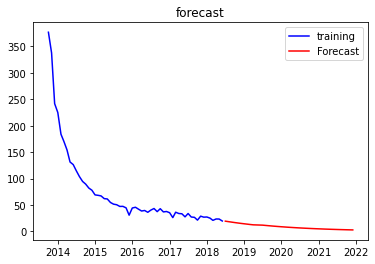

In [23]:
# 直接取指数，即可恢复至原数据
forecast_ARIMA = np.exp(forecast_ARIMA_log)
print (forecast_ARIMA)
plt.plot(ts,label='training',color='blue')
plt.plot(forecast_ARIMA, label='Forecast',color='red')
plt.legend(loc='best')
plt.title('forecast')

Text(0.5, 1.0, 'Oil Production Prediction (ARIMA)')

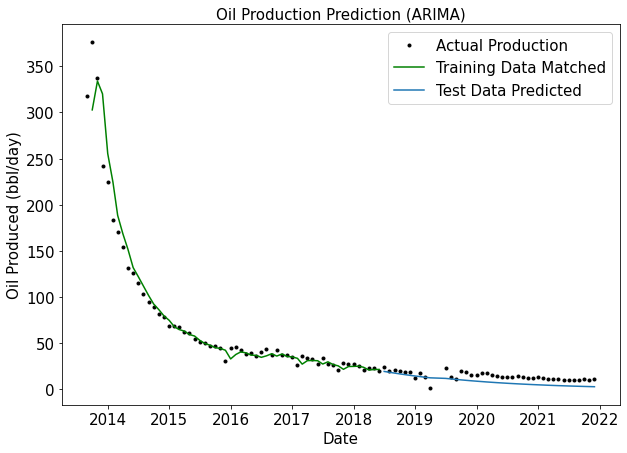

In [26]:
# 绘图
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = ts[log_recover.index]#排除空的数据
plt.figure(figsize=(10,7))

plt.plot(df1['oil/day'],'.',color='black', label='Actual Production')
plt.plot(log_recover,'-',color='green',label='Training Data Matched')
plt.plot(forecast_ARIMA,'-',label='Test Data Predicted')
plt.legend(loc='best',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)

# ax = plt.axes()
# ax.set_ylim(0,1000)

plt.title('Oil Production Prediction (ARIMA)',fontsize=15)

In [28]:
print('train mae: %.2f' % mean_absolute_error(log_recover,ts))
print('train R square: %.2f'% r2_score(log_recover,ts))#
print('train RMSE: %.2f'% np.sqrt(mean_squared_error(log_recover,ts)))

print('test mae: %.2f' % mean_absolute_error(forecast_ARIMA,df1['oil/day'][58:]))
print('test R square: %.2f'% r2_score(forecast_ARIMA,df1['oil/day'][58:]))#
print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA,df1['oil/day'][58:])))

train mae: 8.02
train R square: 0.95
train RMSE: 16.88
test mae: 6.33
test R square: -1.04
test RMSE: 6.85


In [29]:
# only predict one year
print('test 1-year mae: %.2f' % mean_absolute_error(forecast_ARIMA[:12],df1['oil/day'][58:70]))
print('test R square: %.2f'% r2_score(forecast_ARIMA[:12],df1['oil/day'][58:70]))
print('test RMSE: %.2f'% np.sqrt(mean_squared_error(forecast_ARIMA[:12],df1['oil/day'][58:70])))

test 1-year mae: 4.11
test R square: -3.09
test RMSE: 5.14
